In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def plot_waterfall(spacecraft, basenames, t0s, antenna, f0=8420e6, *, fc=None, span=None, tsel=None):
    NFFT = 2**16
    fs = 10.24e6
    n_int = 1562
    tstep = np.timedelta64(round(1e9 * n_int * NFFT / fs), 'ns')
    plt.figure(figsize=(8, 5))
    spectrum = np.zeros(NFFT)
    spectrum_lines = 0
    a_min = np.inf
    b_max = -np.inf
    for basename, t0 in zip(basenames, t0s):
        x = np.fromfile(f'{basename}x', 'float32').reshape(-1, NFFT)
        y = np.fromfile(f'{basename}y', 'float32').reshape(-1, NFFT)
        taxis = t0 + np.arange(x.shape[0]) * tstep
        if tsel is not None:
            tsel_ = (taxis >= tsel[0]) & (taxis <= tsel[1])
            taxis = taxis[tsel_]
            x = x[tsel_]
            y = y[tsel_]
        stokes_I = 0.5 * (x / np.average(x) + y / np.average(y))
        spectrum += np.sum(stokes_I, axis=0)
        spectrum_lines += stokes_I.shape[0]
        a = mdates.date2num(taxis[0])
        b = mdates.date2num(taxis[-1] + tstep)
        a_min = min(a_min, a)
        b_max = max(b_max, b)
        plt.imshow(10*np.log10(stokes_I).T[::-1], aspect='auto',
                   extent=[a, b, 1e-6*(f0 - fs/2), 1e-6*(f0 + fs/2)],
                   vmin=-2, vmax=8)
    plt.xlim((a_min, b_max))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.ylabel('Frequency (MHz)')
    plt.xlabel('UTC time')
    plt.title(f'{spacecraft} waterfall (Stokes I, antenna {antenna})')
    if span is not None:
        plt.ylim(fc-0.5*span, fc+0.5*span)
    plt.figure()
    faxis = f0 + np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))
    if span is not None:
        sel = (faxis * 1e-6 >= fc - 0.5*span) & (faxis * 1e-6 <= fc + 0.5 * span)
    else:
        sel = np.arange(faxis.size)
    plt.plot(faxis[sel] * 1e-6, 10*np.log10(spectrum[sel] / spectrum_lines))
    plt.title(f'{spacecraft} average power spectral density (Stokes I, antenna {antenna})')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('PSD (dB)')

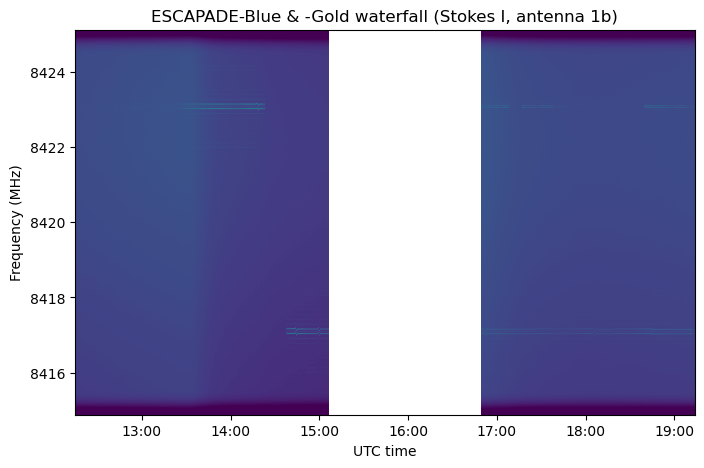

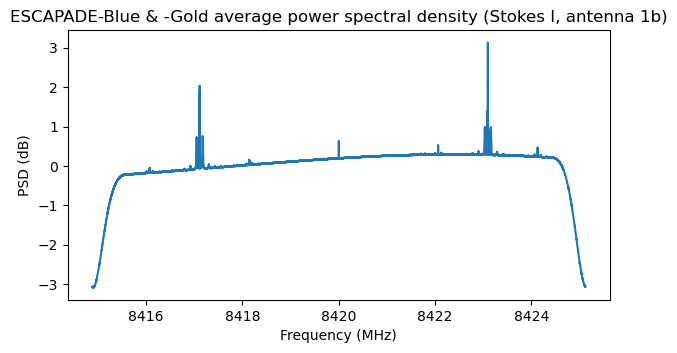

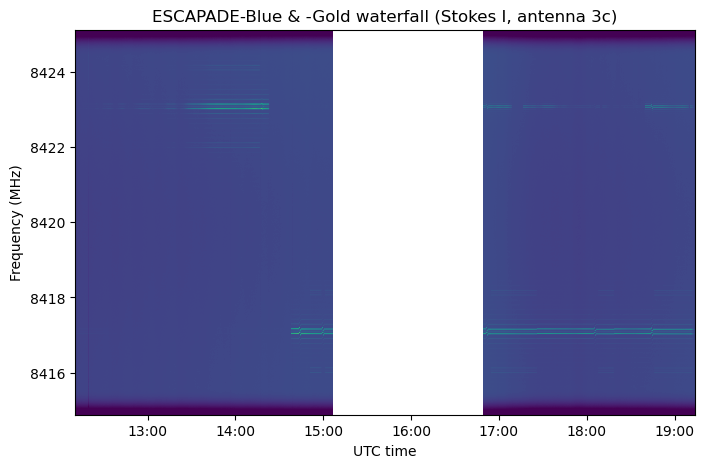

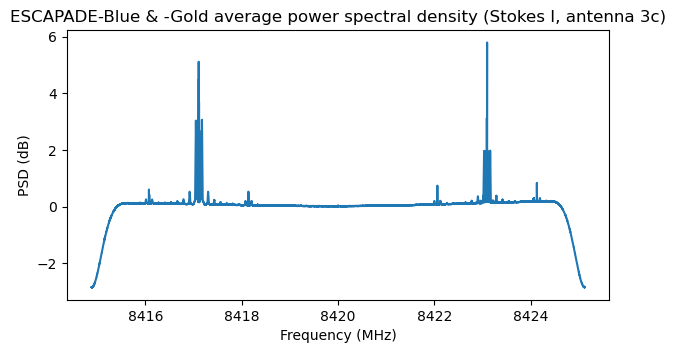

In [3]:
channel = {'1b': 0, '3c': 1}
basenames = {antenna: [
                f'/data/ESCAPADE/waterfalls/ESCAPADE_2025-11-14T11:44:14.068189_{channel[antenna]}',
                f'/data/ESCAPADE/waterfalls/ESCAPADE_2025-11-14T16:49:03.890685_{channel[antenna]}'
            ] for antenna in channel}
t0s = [np.datetime64('2025-11-14T11:44:28.1880249186197917', 'ns'),
       np.datetime64('2025-11-14T16:49:16.1572068929036458', 'ns')]
tsel = {
    '1b': (np.datetime64('2025-11-14T12:14:30'), np.datetime64('2025-11-15T00:00:00')),
    '3c': (np.datetime64('2025-11-14T12:10:10'), np.datetime64('2025-11-15T00:00:00'))
}

for antenna in channel:
    plot_waterfall('ESCAPADE-Blue & -Gold', basenames[antenna], t0s, antenna, tsel=tsel[antenna])

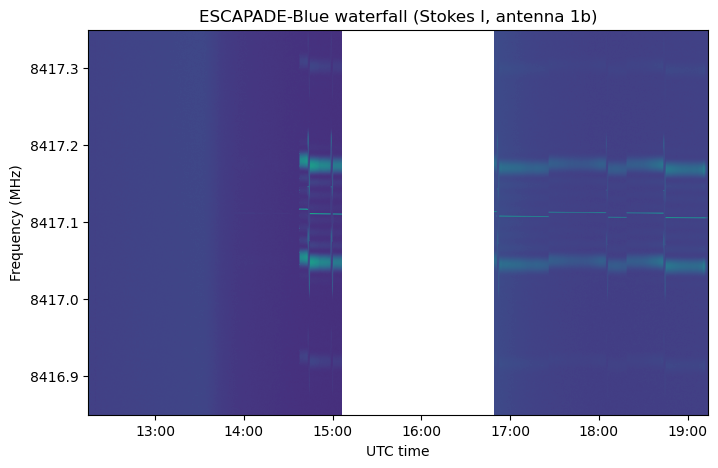

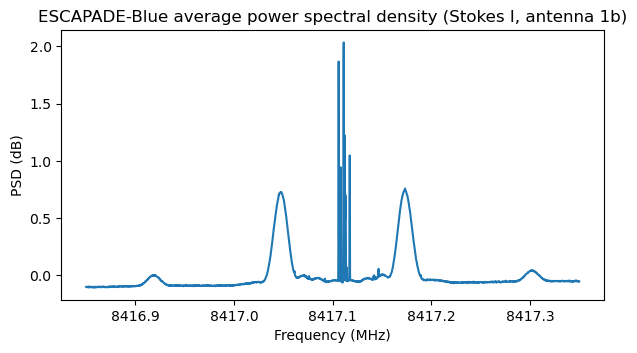

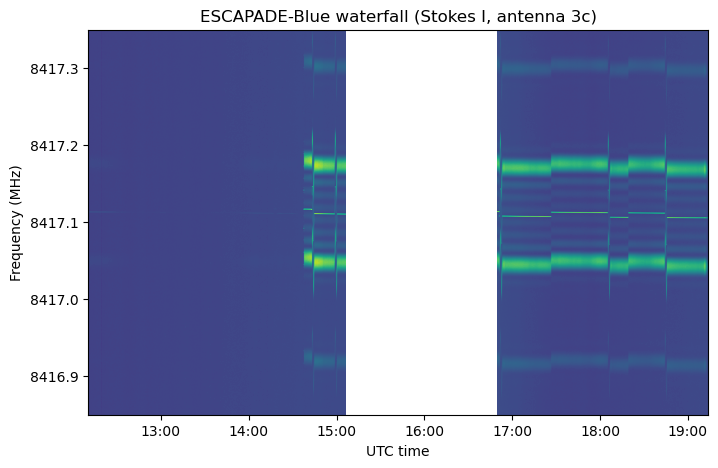

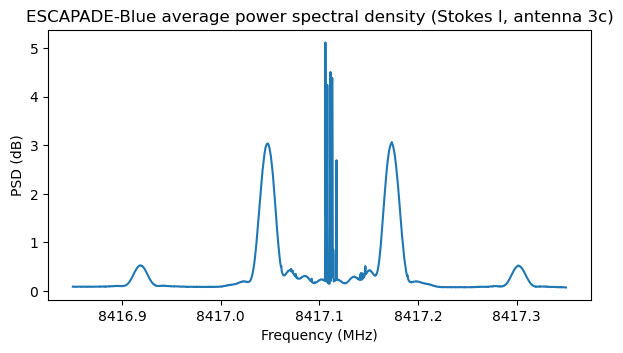

In [4]:
for antenna in channel:
    plot_waterfall('ESCAPADE-Blue', basenames[antenna], t0s, antenna, tsel=tsel[antenna], fc=8417.1, span=0.5)

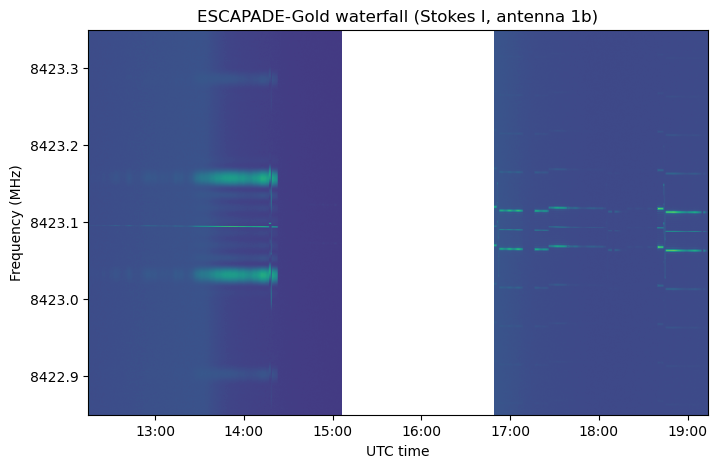

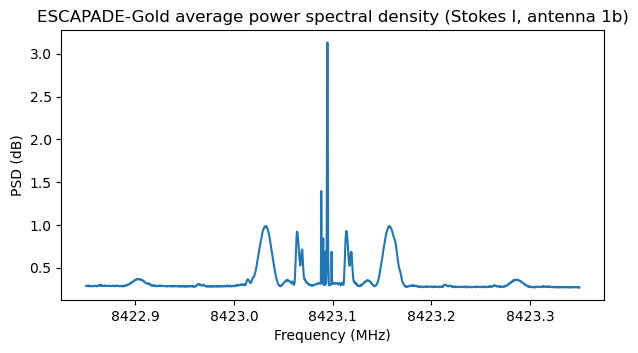

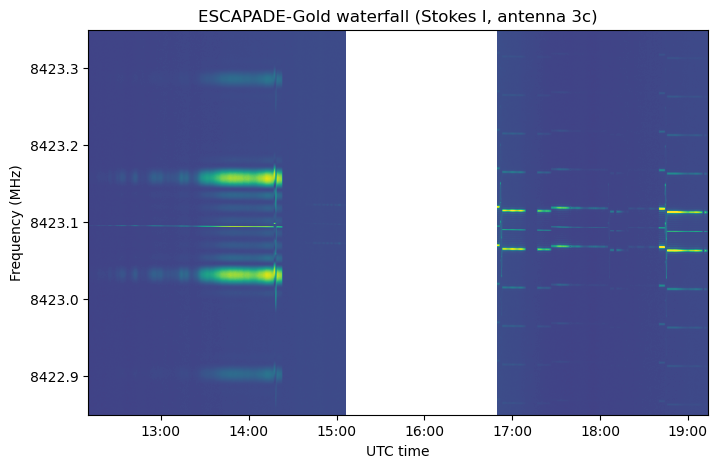

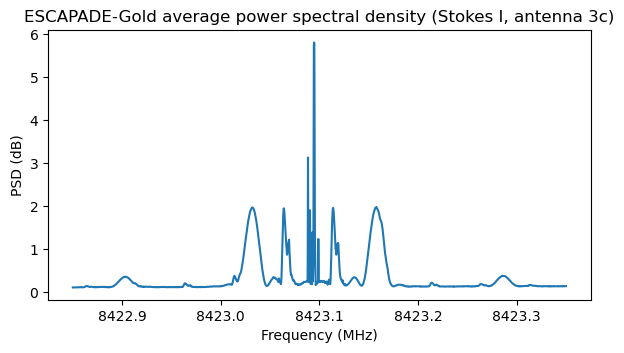

In [5]:
for antenna in channel:
    plot_waterfall('ESCAPADE-Gold', basenames[antenna], t0s, antenna, tsel=tsel[antenna], fc=8423.1, span=0.5)